In [31]:
import numpy as np 
import astropy.units as u
from astropy.table import Table as aTable
# -- desi --
import specsim.simulator
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky

In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
boss_blue = aTable.read(''.join([UT.dat_dir(), 'sky/', 'Bright_BOSS_Sky_blue.fits']))

In [5]:
boss_wlim410 = ((boss_blue[0]['WAVE'] > 405.) & (boss_blue[0]['WAVE'] < 415.))
boss_sky410 = np.array([np.average(boss_blue[i]['SKY'][boss_wlim410])/np.pi for i in range(len(boss_blue))])

In [8]:
specsim_sky = specsim.simulator.Simulator('desi').atmosphere
specsim_wave = specsim_sky._wavelength # Ang

/anaconda2/lib/python2.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [9]:
def KS_sky(airmass, moonill, moonalt, moonsep): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    return specsim_sky.surface_brightness

In [12]:
ks_wlim410 = ((specsim_wave.value > 4050.) & (specsim_wave.value < 4150.))
ks_sky410 = np.zeros(len(boss_blue))
for i in range(len(boss_blue)): 
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    ks_sky410[i] = np.average(ks_i.value[ks_wlim410])

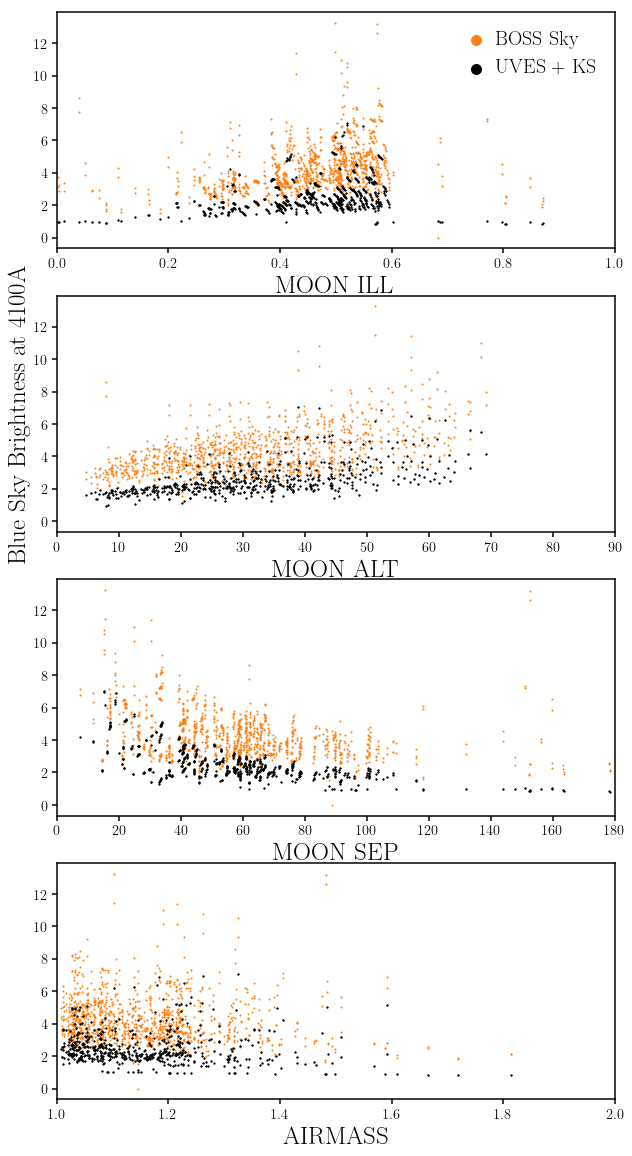

In [13]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410, c='C1', s=1, label='BOSS Sky')
    sub.scatter(boss_blue[k], ks_sky410, c='k', s=1, label='UVES + KS')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('Blue Sky Brightness at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])

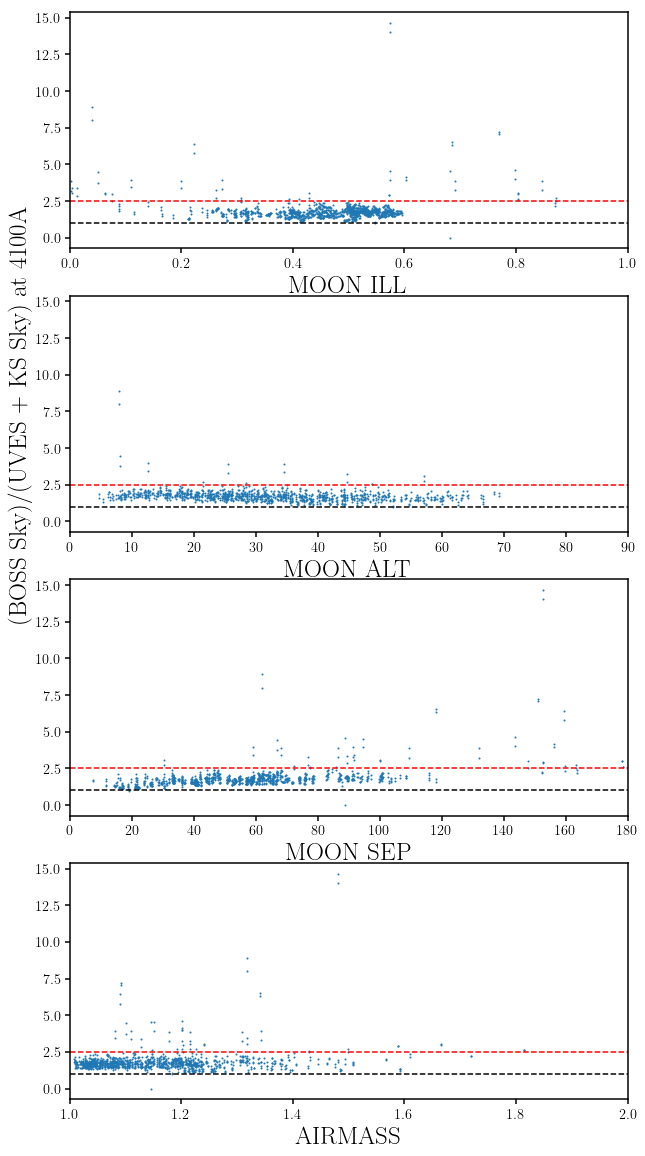

In [15]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410/ks_sky410, c='C0', s=1)
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')
    sub.plot(sub.get_xlim(), [2.5, 2.5], color='r', linestyle='--')

In [16]:
outlier = (boss_sky410/ks_sky410 > 2.5)

In [17]:
print('for %i galaxies BOSS sky is more than 2.5x brighter than UVES + KS' % np.sum(outlier))

for 55 galaxies BOSS sky is more than 2.5x brighter than UVES + KS


In [26]:
meta_cols = ['SUN_ALT', 'SUN_AZ', 'SUN_MOON_SEP', 'MONTH', 'SOLARFLUX']

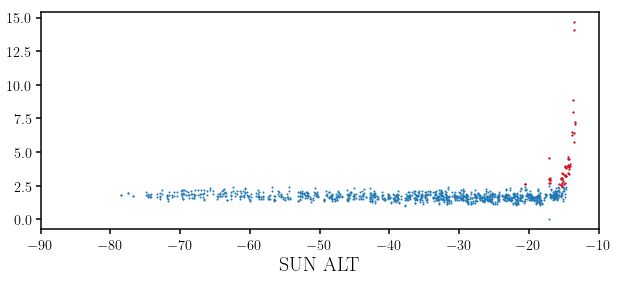

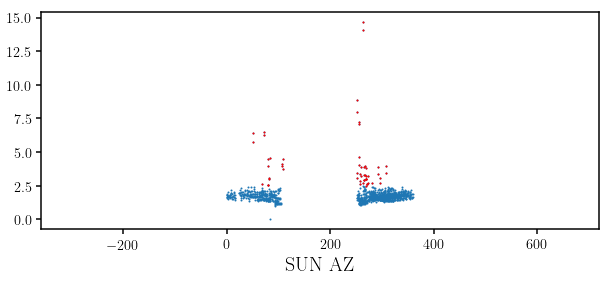

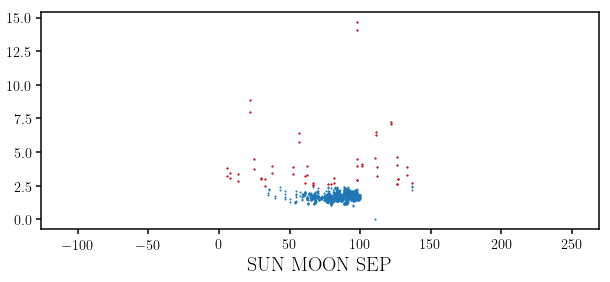

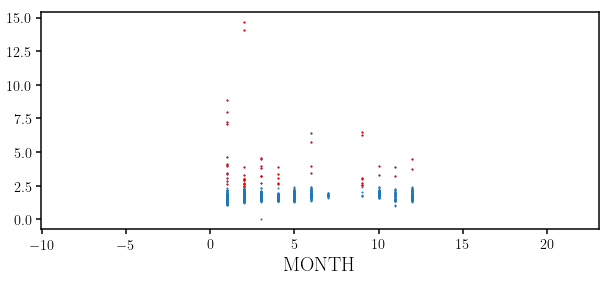

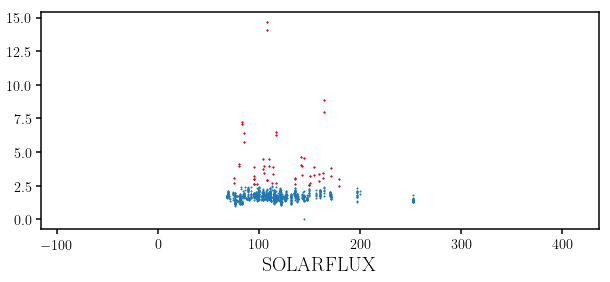

In [30]:
for col in meta_cols: 
    fig = plt.figure(figsize=(10,4))
    sub = fig.add_subplot(111)
    sub.scatter(boss_blue[col], boss_sky410/ks_sky410, c='C0', s=1)
    sub.scatter(boss_blue[col][outlier], (boss_sky410/ks_sky410)[outlier], c='r', s=1)
    sub.set_xlabel(' '.join(col.split('_')), fontsize=20)
    if col == 'SUN_ALT': sub.set_xlim([-90., -10.])

sun altitude is the culprit! So a rescaled KS(1991) moon model with the solar component of Parker's model should do the job